In [ ]:
!pip install torchsummary

In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch
import torchvision

RESIZE=96
CROP_SIZE=(RESIZE,RESIZE)
# do some basic image transformations to improve model generalization
transform = T.Compose([
    T.Resize(RESIZE),
    T.RandomCrop(CROP_SIZE),
    T.RandomHorizontalFlip(),
    T.RandAugment(),
    T.ToTensor(),
    T.Normalize(0,1),
    
])

#download https://www.kaggle.com/datasets/prasunroy/natural-images
dataset = torchvision.datasets.ImageFolder(
    "/kaggle/input/natural-images/natural_images",
    transform=transform)

targets_names = {}
targets = []
for im in dataset.imgs:
    targets.append(im[1])
    targets_names[im[1]]=im[0].split("/")[-2]

# split dataset
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.05,
    stratify=targets
)

train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False,num_workers=4)

In [ ]:
#show dataset samples
from random import randint
index = randint(0,len(dataset)-1)
sample = dataset[index]
print(targets_names[sample[1]])
T.ToPILImage()(sample[0])

In [225]:
import torch
class ResidualBlock(torch.nn.Module):
    """This residual block allows to do basic residual convolution with custom kernel sizes and dilations on each output layer"""
    def __init__(
        self,
        in_channels,                   # Number of input channels.
        out_channels,                  # Number of output channels.
        kernel_size,                   # Kernel size.
        stride,
        dilation,                     # List of dilation values for each output channel.
        activation=torch.nn.ReLU,      # Activation function.
        repeats = 1,                  # how many times repeat block internal transformation
        batch_norm = True #add batch normalization
    ):
        super().__init__()

        correct_x_ksize = 1 if stride==1 else (1+stride)//2 *2 +1
        correct_x_dilation = 1
        correct_x_padding=(correct_x_ksize + (correct_x_ksize - 1) * (correct_x_dilation - 1)) // 2
        if stride>1 or in_channels!=out_channels:
            self.x_correct = \
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size = correct_x_ksize,
                        dilation=correct_x_dilation,
                        stride = stride,
                        padding = correct_x_padding
                    ),
                    torch.nn.BatchNorm2d(out_channels) \
                    if batch_norm else torch.nn.Identity()
                )
        else: 
            self.x_correct = torch.nn.Identity()
            
        if not isinstance(dilation,list):
            dilation=[dilation]*out_channels

        if not isinstance(kernel_size,list):
            kernel_size=[kernel_size]*out_channels
        assert len(dilation) == out_channels, "Number of dilations must match the number of output channels."

        self.activation = activation()

        # If input and output channel sizes differ, we need a projection layer.
        if in_channels != out_channels:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Identity layer if sizes match.
        
        # collapse same-shaped conv blocks
        out_channels_ = [1]
        kernel_sizes_ = [kernel_size[0]]
        dilations_ = [dilation[0]]
        for c_size,c_dilation in list(zip(kernel_size,dilation))[1:]:
            if c_size==kernel_sizes_[-1] and c_dilation==dilations_[-1]:
                out_channels_[-1]+=1
            else:
                out_channels_.append(1)
                kernel_sizes_.append(c_size)
                dilations_.append(c_dilation)
        
        self.convs = []
        self.batch_norms = []
        for v in range(repeats):
            in_ch = in_channels if v==0 else out_channels
            stride_ = stride if v==0 else 1
            # Store the conv layers for each output channel with different dilations.
            
            conv = torch.nn.ModuleList([
                torch.nn.Conv2d(
                    in_channels=in_ch,
                    out_channels=out_channels_[i],          # Output one channel at a time.
                    kernel_size=kernel_sizes_[i],
                    padding=(kernel_sizes_[i] + (kernel_sizes_[i] - 1) * (dilations_[i] - 1)) // 2,
                    padding_mode="zeros",
                    dilation=dilations_[i],
                    stride=stride_
                )
                for i in range(len(out_channels_))
            ])
            
            self.convs.append(conv)
            
            #optionally add batch normalization
            batch_norm = \
                torch.nn.BatchNorm2d(out_channels) \
                if batch_norm else torch.nn.Identity()
            self.batch_norms.append(batch_norm)
        self.convs = torch.nn.ModuleList(self.convs)
        self.batch_norms = torch.nn.ModuleList(self.batch_norms)

    def forward(self, x):
        # Apply each convolution with different dilations to the input and concatenate.
        out_v = x
        for convs,norm in zip(self.convs,self.batch_norms):
            # Fork to parallelize each convolution operation
            futures = [torch.jit.fork(conv, out_v) for conv in convs]
            # Wait for all operations to complete and collect the results
            results = [torch.jit.wait(future) for future in futures]
            out_v = torch.cat(results, dim=1)
            out_v = norm(out_v)
            out_v = self.activation(out_v)
        x=self.x_correct(x)
        # always add x as it was putted-in (without activation applied)
        # so we can get best gradient information flow as x only changed in linear operation
        out_v = out_v + x
        return out_v

In [247]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функци активации используется ReLU
res_conv = ResidualBlock(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    dilation=1,
    activation=torch.nn.ReLU)

x = torch.rand(2, 3, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)
res_conv

torch.Size([2, 3, 192, 192])
torch.Size([2, 10, 192, 192])


ResidualBlock(
  (x_correct): Sequential(
    (0): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): ReLU()
  (correct_channels): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
  (convs): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (batch_norms): ModuleList(
    (0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [246]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"

res_conv = ResidualBlock(
    in_channels=3,
    out_channels=4,
    kernel_size=3,
    stride=1,
    dilation=1,
    activation=torch.nn.Tanh)

x = torch.rand(2, 3, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)
res_conv

torch.Size([2, 3, 192, 192])
torch.Size([2, 4, 192, 192])


ResidualBlock(
  (x_correct): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): Tanh()
  (correct_channels): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (convs): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (batch_norms): ModuleList(
    (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [245]:
# show example of complex residual block
res_conv = ResidualBlock(
    in_channels=3,
    out_channels=4,
    kernel_size=[3,5,5,7],
    stride=3,
    dilation=[1,2,3,4],
    activation=torch.nn.ReLU,
    repeats=3,
    batch_norm=True
)

x = torch.rand(2, 3, 192, 192)
res = res_conv(x)

print(x.shape)
print(res.shape)
res_conv

torch.Size([2, 3, 192, 192])
torch.Size([2, 4, 64, 64])


ResidualBlock(
  (x_correct): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): ReLU()
  (correct_channels): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (convs): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (1): Conv2d(3, 1, kernel_size=(5, 5), stride=(3, 3), padding=(4, 4), dilation=(2, 2))
      (2): Conv2d(3, 1, kernel_size=(5, 5), stride=(3, 3), padding=(6, 6), dilation=(3, 3))
      (3): Conv2d(3, 1, kernel_size=(7, 7), stride=(3, 3), padding=(12, 12), dilation=(4, 4))
    )
    (1-2): 2 x ModuleList(
      (0): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
      (2): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6), dilation=(3, 3))
      (3): 

In [230]:
# show another complex block
a = ResidualBlock(
    in_channels=3,
    out_channels=32,
    kernel_size=[3]*16+[5]*16,
    stride = 2,
    dilation=[1]*8+[2]*8+[1]*8+[2]*8,
    repeats=2,
    activation=torch.nn.ReLU,
    batch_norm=True)
a

ResidualBlock(
  (x_correct): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): ReLU()
  (correct_channels): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (convs): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
      (2): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4), dilation=(2, 2))
    )
    (1): ModuleList(
      (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (2): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Conv2d(32, 8, kernel_size=(5, 5), st

In [231]:
# define simple neural network
class ResidualNetwork(torch.nn.Module):
    def __init__(self,in_channels=3,classes = 100):
        super().__init__()
        self.block1 = ResidualBlock(
            in_channels=in_channels,
            out_channels=64,
            kernel_size= [3]*32        + [5]*16      + [7]*16,
            stride = 2,
            dilation=    [1]*16+[2]*16 + [1]*8+[2]*8 + [1]*8+[2]*8,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)
        self.block2 = ResidualBlock(
            in_channels=64,
            out_channels=128,
            kernel_size=[3]*64        + [5]*64,
            stride = 2,
            dilation=   [1]*32+[2]*32 + [1]*32+[2]*32,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)
        self.block3 = ResidualBlock(
            in_channels=128,
            out_channels=128,
            kernel_size=5,
            stride = 2,
            dilation=1,
            repeats=2,
            activation=torch.nn.ReLU,
            batch_norm=True)

        pool_size = 6
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(pool_size)
        self.fc = torch.nn.Linear(128*pool_size**2,classes)
    
    def forward(self,x):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.block3(x)
        # print(x.shape)
        x = self.avg_pool(x)
        # print(x.shape)
        x=x.flatten(1)
        return self.fc(x)

In [239]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.parallel import DataParallel as DP
import torch.distributed as dist
import os
from torchsummary import summary
device='cuda'

model = ResidualNetwork()
model_dp = DP(model).to(device)

summary(model,(3, RESIZE, RESIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 16, 48, 48]             448
            Conv2d-3            [-1, 8, 48, 48]             608
            Conv2d-4            [-1, 8, 48, 48]             608
            Conv2d-5            [-1, 8, 48, 48]           1,184
            Conv2d-6            [-1, 8, 48, 48]           1,184
       BatchNorm2d-7           [-1, 64, 48, 48]             128
              ReLU-8           [-1, 64, 48, 48]               0
            Conv2d-9           [-1, 16, 48, 48]           9,232
           Conv2d-10           [-1, 16, 48, 48]           9,232
           Conv2d-11            [-1, 8, 48, 48]          12,808
           Conv2d-12            [-1, 8, 48, 48]          12,808
           Conv2d-13            [-1, 8, 48, 48]          25,096
           Conv2d-14            [-1, 8,

In [241]:
import torch.nn.functional as F
from torch.optim import AdamW
from torchmetrics import Accuracy
from tqdm import tqdm

optim = AdamW(model.parameters(), lr=0.001)
metric = Accuracy(task="multiclass", num_classes=len(targets_names.keys())).to(device)
train_acc = []
test_acc = []

model_dp.train()
for epoch in range(10):
    avg_train_acc = 0
    avg_test_acc = 0
    avg_train_loss = 0
    avg_test_loss = 0

    # Training loop with tqdm progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Training", leave=False)
    computed_samples = 0
    for batch in train_loader_tqdm:
        computed_samples+=1
        images = batch[0].to(device)
        classes = batch[1].to(device)
        pred = model_dp(images)  # Use model_dp directly
        loss = F.cross_entropy(pred, classes)
        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_class = torch.argmax(pred, dim=1)
        avg_train_acc += metric(pred_class, classes).item()
        avg_train_loss += loss.item()

        train_loader_tqdm.set_postfix({"loss": avg_train_loss / computed_samples, 
                                       "acc": avg_train_acc / computed_samples})

    # Testing loop with tqdm progress bar
    test_loader_tqdm = tqdm(test_loader, desc=f"Testing", leave=False)
    
    computed_samples = 0
    for batch in test_loader_tqdm:
        computed_samples+=1
        images = batch[0].to(device)
        classes = batch[1].to(device)
        with torch.no_grad():
            pred = model(images)  # No need for model_dp during testing
            pred_class = torch.argmax(pred, dim=1)
            loss = F.cross_entropy(pred, classes)
            avg_test_acc += metric(pred_class, classes).item()
            avg_test_loss += loss.item()

        test_loader_tqdm.set_postfix({"loss": avg_test_loss / computed_samples, 
                                      "acc": avg_test_acc / computed_samples})

    avg_train_acc /= len(train_loader)
    avg_test_acc /= len(test_loader)
    avg_train_loss /= len(train_loader)
    avg_test_loss /= len(test_loader)
    print(f"Epoch {epoch}\n\tTrain\tloss: {avg_train_loss:.4f}\tacc: {avg_train_acc:.2f}\n"
          f"\tTest\tloss: {avg_test_loss:.4f}\tacc: {avg_test_acc:.2f}")

    train_acc.append(avg_train_acc)
    test_acc.append(avg_test_acc)

Epoch 0
	Train	loss: 0.9903	acc: 0.66
	Test	loss: 0.5821	acc: 0.78


Epoch 1
	Train	loss: 0.5743	acc: 0.79
	Test	loss: 0.5677	acc: 0.80


Epoch 2
	Train	loss: 0.4892	acc: 0.83
	Test	loss: 0.4632	acc: 0.82


Epoch 3
	Train	loss: 0.4425	acc: 0.84
	Test	loss: 0.4191	acc: 0.86


Epoch 4
	Train	loss: 0.4014	acc: 0.85
	Test	loss: 0.4716	acc: 0.82


Epoch 5
	Train	loss: 0.3912	acc: 0.85
	Test	loss: 0.4063	acc: 0.85


Epoch 6
	Train	loss: 0.3581	acc: 0.87
	Test	loss: 0.3199	acc: 0.88


Epoch 7
	Train	loss: 0.3353	acc: 0.87
	Test	loss: 0.3804	acc: 0.83


Epoch 8
	Train	loss: 0.3297	acc: 0.88
	Test	loss: 0.3740	acc: 0.84


Epoch 9
	Train	loss: 0.3072	acc: 0.88
	Test	loss: 0.3854	acc: 0.86


In [242]:
model_dp.eval()
true_classes = []
pred_classes = []
for b in tqdm(test_loader,desc="Collecting true/pred classes"):
    images = batch[0].to(device)
    classes = batch[1].to(device)
    pred = model_dp(images)
    pred_class = torch.argmax(pred, dim=1)
    true_classes.extend(classes)
    pred_classes.extend(pred_class)

true_classes = [int(v) for v in true_classes]
pred_classes = [int(v) for v in pred_classes]

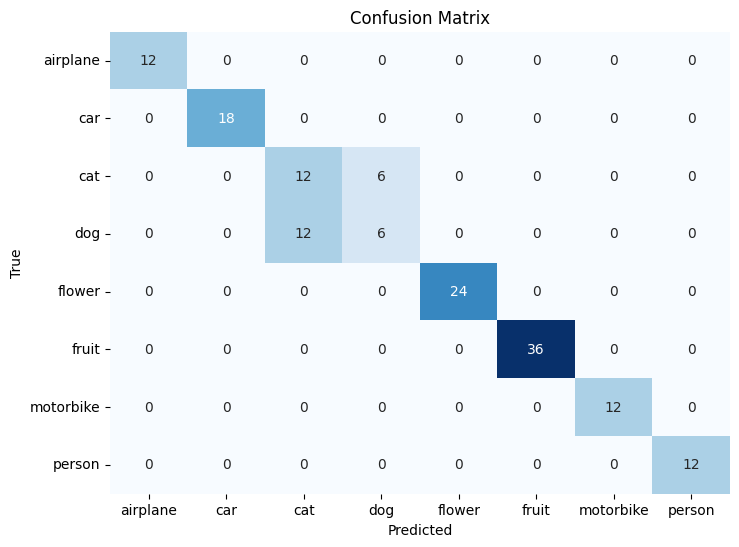

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
classes_names = [targets_names[i] for i in range(len(targets_names.keys()))]
# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()